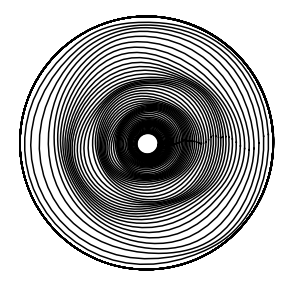

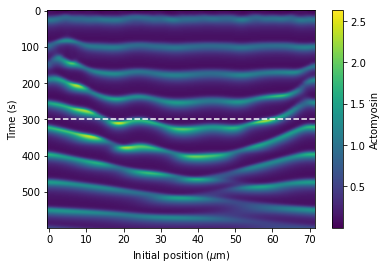

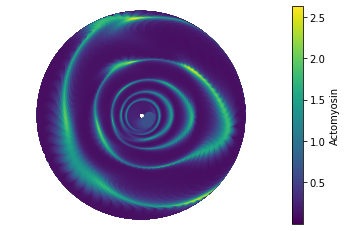

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jul 31 14:27:39 2023

@author: staddon
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def pack_variables(x, rho, myo, l0):
    # Compress into a 1D array
    return np.vstack((x[0, :], x[1, :], rho, myo, l0)).flatten()

def unpack_variables(y):
    # Unflatten 1D array used in scipy solve_ivp function
    y = y.reshape(5, -1)
    x, rho, myo, l0 = y[:2, :], y[2, :], y[3, :], y[4, :]
    return x, rho, myo, l0

def get_length_and_direction_and_normal(x):
    # Returns the length and direction vector of springs
    dx = np.roll(x, -1, axis=1) - x
    length = np.hypot(dx[0], dx[1])
    direction = dx / length
    
    normal = np.zeros(direction.shape)
    normal[0] = direction[1]
    normal[1] = -direction[0]
    
    return length, direction, normal

def get_vertex_normal(x):
    # Returns the normal vector at each vertex
    
    # Vertex normal n is the average of its edge normals n and n-1
    _, _, edge_normal = get_length_and_direction_and_normal(x)
    
    mean_normal = (edge_normal + np.roll(edge_normal, 1, axis=1)) / 2
    v_normal = mean_normal / np.hypot(mean_normal[0], mean_normal[1])
    
    return v_normal


def get_vertex_radial(x):
    return 


def run_sim(savename,
            Sr=6.8744e-4,
            a=0.1609,
            ra=0.3833,
            g=0.1787,
            rg=0.01,
            Sm=0.0076,
            ka=0.1408,
            kd=0.0828,
            Dr=0.1,
            Dm=0.01,
            gamma=1,
            gamma_radial=10,
            tau=5,
            lam=14.3,
            sigma0=24.9 * 2,
            m0=1,
            duration=600,
            t_radial=300,
            dt=1,
            n_points=72,
            radius=15):
    
    # Young's modulus
    youngs = lam ** 2 / tau
    
    # First make the geometry
    x0 = np.zeros((2, n_points))
    theta = np.linspace(0, np.pi * 2, n_points + 1)[:-1]
    x0[0, :] = radius * np.cos(theta)
    x0[1, :] = radius * np.sin(theta)
    
    # Initialise variables
    rho0 = np.zeros(n_points)
    myo0 = np.zeros(n_points)
    
    # Random noise
    rho0 += np.random.uniform(0, 0.1, rho0.shape)
    myo0 += np.random.uniform(0, 0.1, myo0.shape)
    
    l0, dir0, normals = get_length_and_direction_and_normal(x0)
    
    # 1D array for use in solve_ivp
    y0 = pack_variables(x0, rho0, myo0, l0)
    
    def diffusion(var, length, D):
        # Distance from one edge center to the next
        distance_r = (np.roll(length, -1) + length) / 2
        distance_l = (np.roll(length, 1) + length) / 2
        
        dc_r = (np.roll(var, -1) - var)
        dc_l = (np.roll(var, 1) - var)
        
        return D / length * (dc_r / distance_r + dc_l / distance_l)


    def dydt(t, y):
        x, rho, myo, l0 = unpack_variables(y)

        # Vector along edge
        length, direction, _ = get_length_and_direction_and_normal(x)
        
        # Active and elastic stress
        stress_a = -sigma0 * myo / (myo + m0)
        stress_e = youngs * (length - l0) / l0
        edge_force = (stress_e - stress_a) * direction * l0
        
        # Forces on vertex n comes from edge n-1 and n, half because it contributes both ways
        force = (edge_force - np.roll(edge_force, 1, axis=1))
        
        v_normal = get_vertex_normal(x)
        force_normal = (force[0] * v_normal[0] + force[1] * v_normal[1]) * v_normal
        # force_normal = (force[0] * x[0] + force[1] * x[1]) * x / (x[0] ** 2 + x[1] ** 2)
        force_tangential = force - force_normal
        
        # Velocity of each vertex
        if t < t_radial:
            dx_dt = force_tangential / gamma
        else:
            dx_dt = force_tangential / gamma + force_normal / gamma_radial

        # Rest length change
        dl0_dt = (length - l0) / tau
        
        # Chemical reactions
        reaction_rho = Sr + a * rho / (rho + ra) - g * myo * rho / (rho + rg)
        reaction_myo = Sm + ka * rho ** 2 - kd * myo
        
        # Diffusion
        diffusion_rho = diffusion(rho, length, Dr)
        diffusion_myo = diffusion(myo, length, Dm)
        
        # Concentration effects - TO DO: correct!
        dlength_dt = (np.roll(dx_dt[0], -1) - dx_dt[0]) * direction[0] + (np.roll(dx_dt[1], -1) - dx_dt[1]) * direction[1]
        
        strain_rho = -rho * dlength_dt / length
        strain_myo = -myo * dlength_dt / length
        
        drho_dt = reaction_rho + diffusion_rho + strain_rho
        dmyo_dt = reaction_myo + diffusion_myo + strain_myo

        dy_dt = pack_variables(dx_dt, drho_dt, dmyo_dt, dl0_dt)
        
        return dy_dt
    
    t_span = [0, duration]
    t_eval = np.arange(0, duration, dt)
    
    results = solve_ivp(dydt, t_span, y0, t_eval=t_eval)
    
    
    # Convert to a more usable form
    # Extract data as a numpy array, first index is time
    ts = []
    rhos = []
    myos = []
    xs = []
    for i in range(0, results.y.shape[1], 1):
        x, rho, myo, l0 = unpack_variables(results.y[:, i])
        # l, d, _ = get_length_and_direction_and_normal(x)
        
        ts.append(i)
        # ls.append(l)
        rhos.append(rho)
        myos.append(myo)
        xs.append(x.T)
    
    ts = np.array(ts)
    rhos = np.array(rhos)
    myos = np.array(myos)
    xs = np.array(xs)
    
    return ts, rhos, myos, xs
    

if __name__ == '__main__':
    
    """
    Model changes:
        - There is an increased radial friction by a factor of gamma_radial
        - There is no radial contraction for the first t_radial s so that the RhoA 
          pulses

    """
    
    """ Parameters """
    
    # You can set a random seed if you want
    # np.random.seed(0)
    
    # Run simulation for this long before radial motion is allowed
    t_radial = 300
    
    # Friction in the radial direction relative to tangential
    gamma_radial = 10
    
    Sr = 0.01
    sigma0 = 40
    radius = 15
    
    """ Running the simulation """
    t, rho, myo, x = run_sim('test', Sr=Sr, sigma0=sigma0,
                             radius=radius, duration=600, dt=1,
                             t_radial=t_radial,
                             gamma_radial=gamma_radial)
    
    """ Analysing and plotting """

     
    # Plot ring
    for i in range(len(x)):
        if i % 5 == 0:
            x_loop = list(x[i, :, 0]) + [x[i, 0, 0]]
            y_loop = list(x[i, :, 1]) + [x[i, 0, 1]]
            #x_loop = list(x[i, :, 0]) + [x[i, 0, 0]]
            #y_loop = list(x[i, :, 1]) + [x[i, 1, 0]]
            plt.plot(x_loop, y_loop, color='k')
    
    plt.axis('equal')
    plt.axis('off')
    plt.gcf().set_size_inches(5, 5)
    
    plt.show()
    

    # Myosin concentration in each spring element - ie initial position    
    plt.imshow(myo, aspect='auto', interpolation='bicubic')
    plt.axhline(300, color='w', ls='--')
    plt.colorbar(label='Actomyosin')
    plt.xlabel('Initial position ($\mu$m)')
    plt.ylabel('Time (s)')
    
    plt.show()

    # Myosin concentration in real coordinates
    plt.scatter(x[:, :, 0], x[:, :, 1], c=myo, s=100)
    plt.colorbar(label='Actomyosin')
    plt.axis('equal')
    plt.axis('off')
   
    plt.show()

